In [262]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Data preparation

In [263]:
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'

In [264]:
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [265]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [266]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [267]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


# Data partitioning

In [268]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [269]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100,stratify = y)

# k Nearest Neighbor

In [270]:
clf = KNeighborsClassifier(n_neighbors=16, weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.780982905982906
Precision 0.674863387978142
Recall 0.4591078066914498
F1-score [0.8556338  0.54646018]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1334
           1       0.67      0.46      0.55       538

    accuracy                           0.78      1872
   macro avg       0.74      0.68      0.70      1872
weighted avg       0.77      0.78      0.77      1872



### Gridsearch

In [271]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [272]:
parameters = {'n_neighbors': np.arange(1, 10 + 1), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters,cv = 4)
search.fit(X_train, y_train)
report(search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.776 (std: 0.003)
Parameters: {'n_neighbors': 8, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.776 (std: 0.001)
Parameters: {'n_neighbors': 9, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.774 (std: 0.004)
Parameters: {'n_neighbors': 5, 'weights': 'distance'}



In [273]:
clf = search.best_estimator_
clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')

Text(0, 0.5, 'Error Rate')

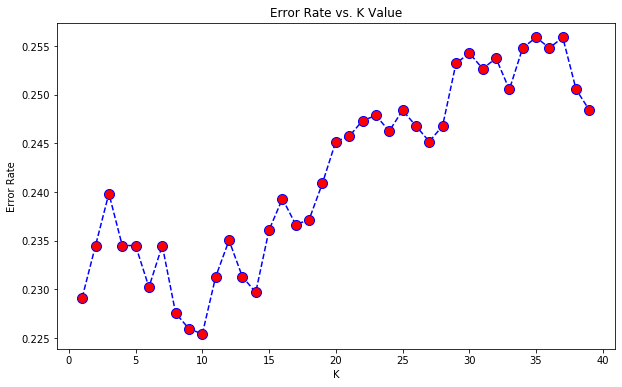

In [274]:
error_rate = []
# Might take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [275]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7788461538461539
Precision 0.6383928571428571
Recall 0.5315985130111525
F1-score [0.84989123 0.5801217 ]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1334
           1       0.64      0.53      0.58       538

    accuracy                           0.78      1872
   macro avg       0.73      0.71      0.72      1872
weighted avg       0.77      0.78      0.77      1872



array([[1172,  162],
       [ 252,  286]], dtype=int64)

In [276]:
accuracy = cross_val_score(clf, X, y, cv=5)
print('Accuracy:', np.mean(accuracy),accuracy)
print()
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision:', np.mean(precision), precision)
print()
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall:', np.mean(recall),recall)
print()
f1_score = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print('F1-score:', np.mean(f1_score),f1_score)

Accuracy: 0.688894770381943 [0.67361111 0.71581197 0.69909139 0.67610903 0.67985035]

Precision: 0.6375304520954416 [0.62138728 0.62962963 0.62253521 0.64329268 0.67080745]

Recall: 0.5041860465116278 [0.5        0.51395349 0.51395349 0.49069767 0.50232558]

F1-score: 0.5891855995060332 [0.59350961 0.61383204 0.60902734 0.55536514 0.57419386]


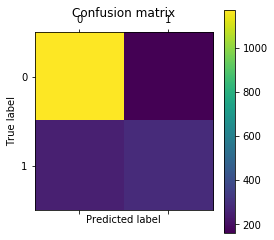

In [277]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### An example from sklearn

In [278]:
X_train[:,:1].shape

(7485, 1)

In [279]:
""""
from sklearn import datasets
from matplotlib.colors import ListedColormap

n_neighbors = 6


# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = X_train[:, 1:3]
y = y_train

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
"""

'"\nfrom sklearn import datasets\nfrom matplotlib.colors import ListedColormap\n\nn_neighbors = 6\n\n\n# we only take the first two features. We could avoid this ugly\n# slicing by using a two-dim dataset\nX = X_train[:, 1:3]\ny = y_train\n\nh = .02  # step size in the mesh\n\n# Create color maps\ncmap_light = ListedColormap([\'orange\', \'cyan\', \'cornflowerblue\'])\ncmap_bold = ListedColormap([\'darkorange\', \'c\', \'darkblue\'])\n\nfor weights in [\'uniform\', \'distance\']:\n    # we create an instance of Neighbours Classifier and fit the data.\n    clf = KNeighborsClassifier(n_neighbors, weights=weights)\n    clf.fit(X, y)\n\n    # Plot the decision boundary. For that, we will assign a color to each\n    # point in the mesh [x_min, x_max]x[y_min, y_max].\n    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1\n    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                         np.arange(y_min, y_max, h))\n    Z

# ROC curve

In [280]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc

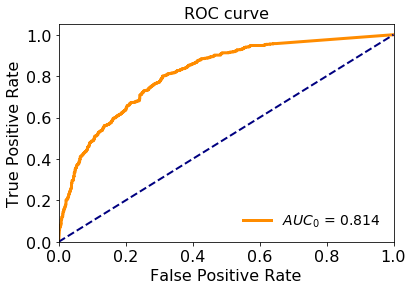

In [281]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

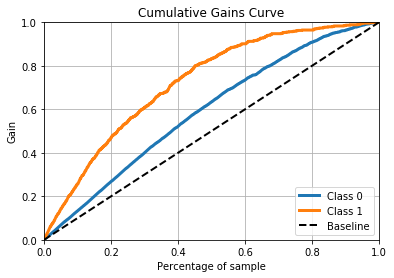

In [282]:
predicted_probas = clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

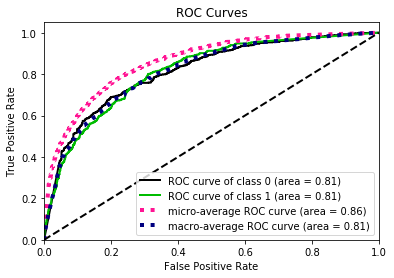

In [283]:
plot_roc(y_test, y_score)
plt.show()

# Lift chart

In [284]:
from scikitplot.metrics import plot_lift_curve

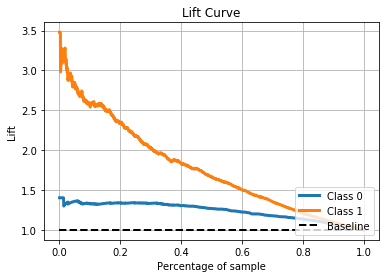

In [285]:
plot_lift_curve(y_test, y_score)
plt.show()